# Turbine Model

## Load Libs


In [18]:
import os
from datetime import datetime as dt

import icecream
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as L
import torch
from icecream import ic
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

import hephaestus as hp
from hephaestus.timeseries_models import tabular_collate_fn

# %%
torch.set_default_dtype(torch.float32)
# %%
icecream.install()
ic_disable = True  # Global variable to disable ic
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)
# pd.options.mode.copy_on_write = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [19]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    print("MPS available")
else:
    print("CUDA not available. Checking why...")
    import os

    print(f"CUDA_VISIBLE_DEVICES: {os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set')}")

PyTorch version: 2.6.0
CUDA available: False
MPS available


## Load Data

We use `line2df` to load the original data from
[PolyMathic](https://polymathic-ai.org/blog/xval/). Since we've already transformed the
data into a parquet file, we can load it directly.


In [26]:
df = pd.read_csv("data/nox/train.csv")
df.columns = df.columns.str.lower()


scaler = StandardScaler()
df["cat_column"] = "category"
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df["idx"] = df.index // 64
print(f"Dataframe shape: {df.shape}")
df.head()

Dataframe shape: (5187, 13)


,at,ap,ah,afdp,gtep,tit,tat,tey,cdp,co,nox,cat_column,idx
0,-0.590991,-1.010456,0.656093,0.616453,-0.300483,0.102424,0.658586,-0.074636,-0.315367,-0.325677,0.600146,category,0
1,1.002151,-0.441713,-2.340118,-1.783316,-1.600143,-2.087644,0.648898,-1.910478,-1.802622,0.503251,-0.535772,category,0
2,-0.408671,0.537789,-0.396034,-1.752509,-1.458189,-1.684374,0.659797,-1.451052,-1.457319,1.212676,0.734914,category,0
3,2.056941,-0.504906,-1.940098,0.756679,0.975480,0.927578,-0.455523,0.674953,0.947528,-0.639861,-1.400202,category,0
4,-0.448470,0.411402,0.581204,-0.881411,-0.356939,0.071403,0.659797,-0.141597,-0.370581,0.084497,0.205965,category,0


In [28]:
# df_categorical = df.select_dtypes(include=["object"]).astype(str)
# unique_values_per_column = df_categorical.apply(
#     pd.Series.unique
# ).values  # .flatten().tolist()
# flattened_unique_values = np.concatenate(unique_values_per_column).tolist()
# unique_values = list(set(flattened_unique_values))
# unique_values

In [29]:
# df.select_dtypes(include="object").groupby(
#     df.select_dtypes(include="object").columns.tolist()
# ).size().reset_index(name="count")

In [30]:
df = df.reset_index(drop=True)
# df = df.head(
#     5_000
# )  # For testing purposes only, train on the full dataset in production

In [31]:
# Get train test split at 80/20
time_series_config = hp.TimeSeriesConfig.generate(df=df)
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = hp.TimeSeriesDS(train_df, time_series_config)
test_ds = hp.TimeSeriesDS(test_df, time_series_config)
len(train_ds), len(test_ds)

(64, 18)

In [32]:
time_series_config.n_columns

12

In [33]:
N_HEADS = 8 * 4
# tabular_decoder = TimeSeriesDecoder(time_series_config, d_model=512, n_heads=N_HEADS)
tabular_decoder = hp.TabularDecoder(time_series_config, d_model=512, n_heads=N_HEADS)

In [ ]:
logger_variant_name = "Nox"
logger_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")
logger_name = f"{logger_time}_{logger_variant_name}"
print(f"Using logger name: {logger_name}")
logger = TensorBoardLogger(
    "runs",
    name=logger_name,
)
early_stopping = EarlyStopping(monitor="val_loss", patience=3, mode="min")
trainer = L.Trainer(
    max_epochs=200, logger=logger, callbacks=[early_stopping], log_every_n_steps=1
)
train_dl = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=tabular_collate_fn,
    num_workers=7,
    persistent_workers=True,
)
test_dl = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=tabular_collate_fn,
    num_workers=7,
    persistent_workers=True,
)
trainer.fit(tabular_decoder, train_dl, test_dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TimeSeriesDecoder | 43.5 M | train
----------------------------------------------------
43.5 M    Trainable params
0         Non-trainable params
43.5 M    Total params
174.105   Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Using logger name: 2025-03-20T08:43:21_Wells


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [41]:
df_comp = hp.show_results_df(
    model=tabular_decoder,
    time_series_config=time_series_config,
    dataset=train_ds,
    idx=0,
)

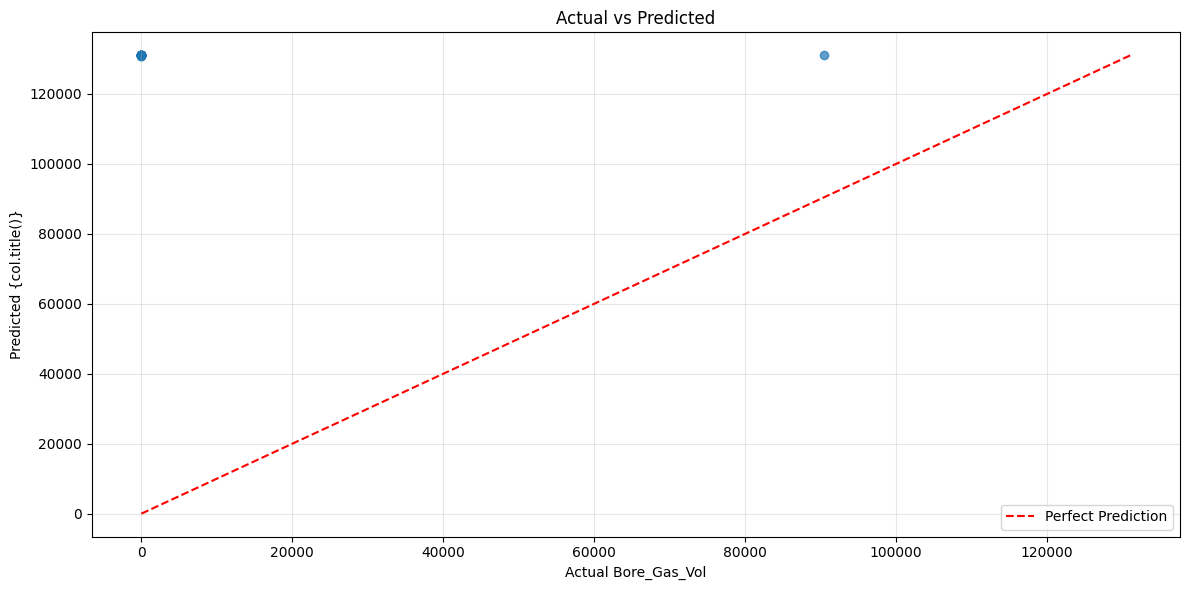

In [42]:
col_name = "bore_gas_vol"
hp.plot_col_error(df_comp, col_name)

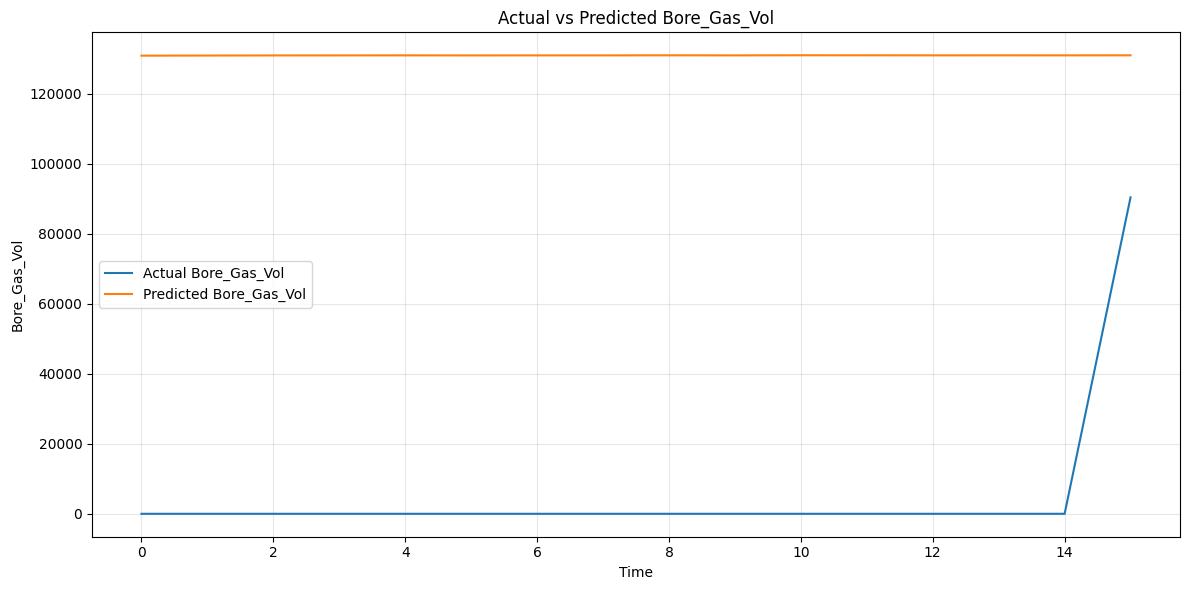

In [43]:
hp.plot_col_comparison(df_comp, col_name)

KeyError: 'time_step'

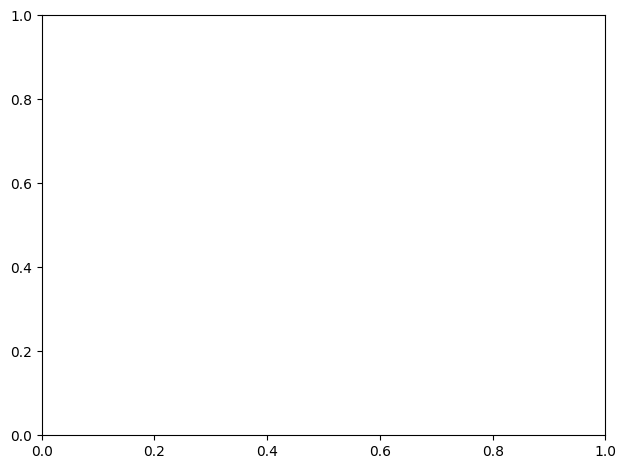

In [40]:
# Create initial inputs from the test dataset
test_idx = 5  # Choose a test sample
stop_idx = 10  # Start predictions after this timestep
inputs = hp.AutoRegressiveResults.from_ds(test_ds, test_idx, stop_idx=stop_idx)

# Generate predictions for multiple steps
num_prediction_steps = 20
for _ in range(num_prediction_steps):
    inputs = hp.auto_regressive_predictions(tabular_decoder, inputs)

# Process the results into DataFrames for analysis
actual_inputs = test_ds[test_idx]
actual_df = hp.create_test_inputs_df(
    hp.AutoRegressiveResults(actual_inputs.numeric, actual_inputs.categorical),
    time_series_config,
)
predicted_df = hp.create_test_inputs_df(inputs, time_series_config)

# Plot comparisons for several key columns
# Create a 2x2 grid of plots for different planet positions
plt.figure(figsize=(16, 12))
columns_to_plot = ["planet0_x", "planet0_y", "planet1_x", "planet1_y"]

for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 2, i + 1)

    # Only plot from stop_idx onward
    ax = plt.gca()
    ax.plot(
        predicted_df["time_step"],
        predicted_df[col],
        "r-",
        label="Predicted",
    )
    ax.plot(
        actual_df["time_step"],
        actual_df[col],
        "b--",
        label="Actual",
    )

    # Add vertical line to mark prediction start
    ax.axvline(
        x=predicted_df["time_step"][stop_idx], color="gray", linestyle="--", alpha=0.7
    )

    # Add annotations
    ax.set_title(f"{col} Trajectory")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Position")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("Autoregressive Predictions vs Actual Values", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add space for the suptitle
plt.show()